In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE  # buat handle imbalance

In [3]:
# misal data udah bersih dari notebook sebelumnya
df = pd.read_csv("../dataset/cleanedData.csv")

X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [ ]:
#handle class imbalance pake smote
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [5]:
#hyperparameter tuning 
#kasarnya proses nyari kombinasi pengaturan terbaik buat model biar perfomancenya maksimal
param_grid = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "C": [0.01, 0.1, 1, 10],
    "solver": ["lbfgs", "liblinear", "saga"]
}

logreg = LogisticRegression(max_iter=5000)

grid = GridSearchCV(
    logreg, param_grid, 
    cv=5, scoring="roc_auc", n_jobs=-1, verbose=2
)
grid.fit(X_train_res, y_train_res)

print("Best Parameters:", grid.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\

Best Parameters: {'C': 0.01, 'penalty': None, 'solver': 'lbfgs'}


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
best_logreg = grid.best_estimator_

y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.7684869169510807
ROC-AUC: 0.8170491808716912
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1291
           1       0.56      0.63      0.59       467

    accuracy                           0.77      1758
   macro avg       0.71      0.72      0.72      1758
weighted avg       0.78      0.77      0.77      1758



accuracy turun karena datasetnya abis dihandle imbalance datanya. yang tadinya model "main aman" by selecting the mayority of the data, sekarang gabisa gitu aja. tp recall naik

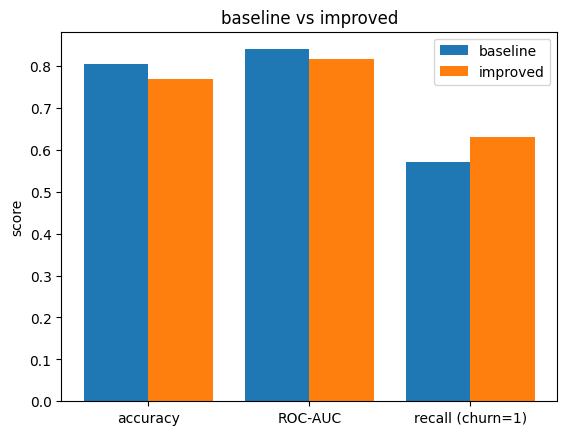

In [1]:
import matplotlib.pyplot as plt

metr = ["accuracy", "ROC-AUC", "recall (churn=1)"]
baseline = [0.806, 0.84, 0.57]
improved = [0.768, 0.817, 0.63]



x = range(len(metr))
plt.bar(x, baseline, width=0.4, label="baseline", align="center")
plt.bar([i+0.4 for i in x], improved, width=0.4, label="improved", align="center")

plt.xticks([i+0.2 for i in x], metr)
plt.ylabel("score")
plt.title("baseline vs improved")
plt.legend()
plt.show()


- baseline model punya accuracy lebih tinggi (0.806), tapi cenderung bias ke kelas mayoritas, recall churn hanya 0.57.
- setelah SMOTE + tuning, accuracy turun sedikit (0.768), tapi recall churn meningkat ke 0.63, artinya lbh banyak customer churn yang berhasil diprediksi.

di kasus churn prediction recall biasanya lebih penting daripada accuracy krn lebih baik mendeteksi calon churn walau ada false positive, daripada kehilangan tanpa peringatan